In [72]:
%load_ext autoreload
%autoreload 2

import sys
sys.dont_write_bytecode = True

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
#imports
import os
import yaml
import json
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score
from catboost import CatBoostClassifier

from utils import plot_roc_curve
from utils import find_max_fscore 
from utils import plot_confusion_matrix
from utils import plot_feature_importnaces

In [74]:
#params
with open("params.yml", 'r') as file:
    params = yaml.safe_load(file)

root_path = params['root_path']
filepath_input = root_path + 'data/raw_data_7d/' #МЕНЯЕТСЯ

feature_cols = ['close_price','n_trades','base_volume','buy_base','vol_per_trade']

shift_b = 18
shift_f = 7
anomaly_crtiretion = 1.0050

cb_params = {
    'iterations': 300,
    'learning_rate': 0.03,
    'depth': 5,
    'l2_leaf_reg': 2,
    'rsm': 0.7,
    'verbose': False,
    'allow_writing_files': False,
    'random_state': 42
}

In [75]:
###parsing csv - МЕНЯЕТСЯ

#list of file
files=os.listdir(filepath_input)

#read as pd file
kline_csv=[]
for name in files:
    f= pd.read_csv(filepath_input+name, sep = ';')
    kline_csv.append(f)
df = pd.concat(kline_csv)

#drop cols
cols_drop = ['symbol', 'interval', 'first_trade_id', 'last_trade_id']
df = df.drop(cols_drop, axis = 1)

#change cols name
new_cols_name = [
    'event_time',
    't_start',
    't_end',
    'open_price',
    'high_price',
    'low_price',
    'close_price',
    'n_trades',
    'is_closed',
    'base_volume',
    'quote_volume',
    'buy_base',
    'buy_quote'
]
df.columns = new_cols_name

#change "is_closed" values
df.is_closed = df.is_closed.replace({'f' : False, 't' : True})

#vol_per_trade
df['vol_per_trade'] = df['quote_volume'] / df['n_trades']

In [76]:
###generate features

#deltas
for col in feature_cols:
    df[f'{col}_delta'] = df[col].shift(-1) - df[col]    

#correction
condition = (df['is_closed'] == True)
feature_cols_delta = [col + '_delta' for col in feature_cols]
for col_1, col_2 in zip(feature_cols,feature_cols_delta):
    df[col_2].loc[condition] = (df[col_1].loc[condition].values) + (df[col_2].loc[condition].values)

#shift deltas
data_temp = pd.DataFrame()
for col in feature_cols_delta:
    for shift in range(shift_b+1):
        #deltas
        data_temp[f'{col}_{shift}'] = df[col].shift(shift)
        #cumsum deltas
        if shift > 1:
            data_temp[f'{col}_0_{shift-1}'] = df[col].rolling(shift).sum()
df = pd.concat([df.drop(feature_cols_delta, axis = 1), data_temp], axis = 1)
df = df.dropna().reset_index(drop = True)

#target calculation
df['anomaly_t_start'] = np.where(
    df.close_price > df.open_price,
    df.high_price/df.open_price,
    df.open_price/df.low_price
    )
df['anomaly_t_end'] = df['anomaly_t_start'].shift(-shift_f)
df['target'] = df['anomaly_t_end'] > anomaly_crtiretion
df = df.dropna()

In [78]:
###process_features

#correction_1
df['t_start'] = df['event_time']
df['t_end'] = df['event_time'].shift(-1)
df = df.dropna()

# #correction_2 - МЕНЯЕТСЯ!!!
# df['event_time'] = pd.to_datetime(df['event_time'].apply(
#     lambda x: datetime.fromtimestamp(x/1000.0)
#     ))
# df['t_start'] = pd.to_datetime(df['t_start'].apply(
#     lambda x: datetime.fromtimestamp(x/1000.0)
#     ))
# df['t_end'] = pd.to_datetime( df['t_end'].apply(
#     lambda x: datetime.fromtimestamp(x/1000.0)
#     ))

#correction_3
df = df.drop_duplicates('event_time', keep = 'first')
df = df.sort_values(by='event_time').reset_index(drop = True)
df = df.drop('event_time' , axis = 1)
df = df.round(2)
df = df.reset_index(drop = True)

#select
dt_cols = ['t_start', 't_end']
feature_cols = feature_cols
delta_cols = [col for col in df.columns if 'delta' in col]

df_event = df[dt_cols + feature_cols + ['target']]
df_period = df[dt_cols + delta_cols + ['target']]
df_model = df[delta_cols + ['target']]

In [81]:
#split
train, test = train_test_split(df_model, test_size = 0.2, random_state = 42, shuffle = False)

x_train = train.drop('target', axis = 1)
y_train = train.target.astype(int)

x_test = test.drop('target', axis = 1)
y_test = test.target.astype(int)

#fit best model
model = CatBoostClassifier(**cb_params)
model.fit(x_train, y_train)

# predict train probabilities
y_train_pred_proba = model.predict_proba(x_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

# predict test probabilities
y_test_pred_proba = model.predict_proba(x_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

#plot_find_max_fscore
opt_cutoff = find_max_fscore(y_test, y_test_pred_proba)

#calculate metrics
f_score_train = round(100*f1_score(y_train, (y_train_pred_proba > opt_cutoff), pos_label=1, average='binary'),2)
f_score_test  = round(100*f1_score(y_test , (y_test_pred_proba  > opt_cutoff), pos_label=1, average='binary'),2)

metrics_df = pd.DataFrame({'f_score_train':[f_score_train],
                           'f_score_test':[f_score_test]})

display(metrics_df)

,f_score_train,f_score_test
0,55.3,47.91


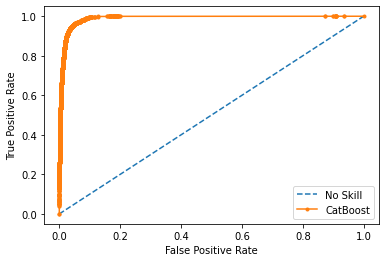

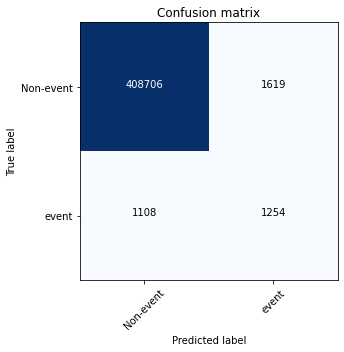

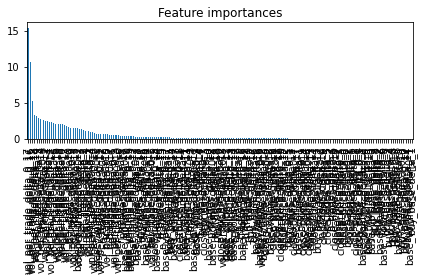

In [82]:
cutoff = opt_cutoff

# plot roc curve
plot_roc_curve(y_test, y_test_pred_proba)

#plot_confusion_matrix
plot_confusion_matrix(y_test, y_test_pred_proba, cutoff)

#plot_feature_importances
plot_feature_importnaces(model,x_train)